In [1]:
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import numpy as np
import unittest


In [2]:
# Util functions

def gaussian_distribution_density_data(mu, sigma):
    """
        Given a mu and a sigma, this function returns a tuple representing the X and Y of the PDF

        params: mu, sigma <numbers>
        return: X, Y of the normal distribution()
    """
    data = torch.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    gaussian_distribution = (1/(sigma * torch.sqrt(torch.tensor(2) * torch.pi))) * torch.exp(-0.5 * ((data - mu) / sigma)**2)
    return data, gaussian_distribution

def plot(X, mu1, sigma1, mu2, sigma2, title=''):
    # a) Scatter Plot with histograms
    # Histograms
    plt.hist(X, bins=50, alpha=0.25, density = True, histtype='bar', ec='black')
    # Scatter
    plt.scatter(X,torch.zeros(len(X)))
    # Density
    x1, gaussian_density_1 = gaussian_distribution_density_data(mu1, sigma1)
    x2, gaussian_density_2 = gaussian_distribution_density_data(mu2, sigma2)
    plt.plot(x1, gaussian_density_1, label=f'Gaussian (mu={mu1}, sigma={sigma1})', color='red')
    plt.plot(x2, gaussian_density_2, label=f'Gaussian (mu={mu2}, sigma={sigma2})', color='blue')
    if len(title):
        plt.title(title)
    plt.legend()
    plt.show()


# Trabajo Práctico 0: Algoritmo de Maximización de la Esperanza

X =  tensor([ 8.3580,  9.2747, 12.8713, 10.0264, 11.4945,  8.6632,  8.3919,  5.0736,
        10.9247,  7.7056, 11.9216, 12.7382,  4.7086,  8.4183,  8.6647, 12.3396,
         5.0751,  9.9457, 14.5482, 12.0961, 27.2959, 33.5541, 33.0648, 33.7966,
        30.5963, 31.3245, 25.1300, 32.0962, 29.9598, 31.2214, 28.7167, 29.5940,
        28.7472, 28.5848, 28.8557, 31.6983, 29.3168, 27.6589, 32.4012, 27.7688])


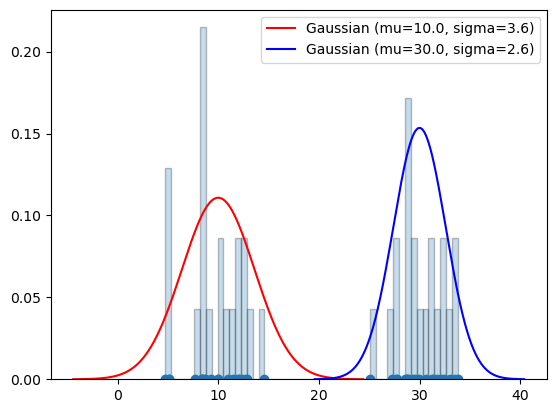

In [3]:
n = 20
mu1 = 10.0
sigma1 = 3.6
mu2 = 30.0
sigma2 = 2.6

# 1)
# Generates data that follows two 2gaussian distributions based on a set of parameters.
def generate_data(n, mu1, sigma1, mu2, sigma2):

  # Generate distributions
  normal_dist1 = torch.distributions.Normal(torch.tensor([mu1]), torch.tensor([sigma1]))
  normal_dist2 = torch.distributions.Normal(torch.tensor([mu2]), torch.tensor([sigma2]))

  # Take a sample from each dist
  gaussian_sample1 = normal_dist1.sample((n,1)).squeeze()
  gaussian_sample2 = normal_dist2.sample((n,1)).squeeze()

  # Concatenate the 2 samples
  X =  torch.cat((gaussian_sample1, gaussian_sample2))
  return X

X = generate_data(n, mu1, sigma1, mu2, sigma2)
print('X = ', X)

plot(X, mu1, sigma1, mu2, sigma2)



In [4]:
# 2)
def init_random_parameters(k=2, range=50):
  """
      Generates randombly mu and sigma parameters
      params: k, range
      return: A Kx2 matrix where colum 0 corresponds to mu and column 1 to sigma
  """
  return torch.rand((k, 2))*range

P = init_random_parameters()
print('P = ', P)

P =  tensor([[41.5269, 41.1535],
        [12.8319,  6.1835]])


In [97]:
# 3)
def calculate_log_likelihood_gaussian_observation(x_n, mu_k, sigma_k):
  # Nota: tal vez deberíamos poner en el latex el proceso desde la función de likelihood sin log hasta esta versión
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)

likelihood_test = calculate_log_likelihood_gaussian_observation(X[0], mu1, sigma1)
print('likelihood_test = ', likelihood_test)

class LikelihoodGuassianUnitTest(unittest.TestCase):

    def test_likelihood_lower_real(self):
      test_data = torch.distributions.Normal(torch.tensor([4.0]), torch.tensor([8.0]))
      test_gaussian_sample = torch.tensor(test_data.sample((30,1)).squeeze())
      
      real_lgo = calculate_log_likelihood_gaussian_observation(test_gaussian_sample, 4.0, 8.0)
      false_lgo = calculate_log_likelihood_gaussian_observation(test_gaussian_sample, 40.0, 7.0)
      self.assertTrue(abs(real_lgo) < abs(false_lgo))

    def test_likelihood_value(self):
      test_gaussian_sample = torch.tensor([0.34, 0.45, 0.78])
      likelihood = calculate_log_likelihood_gaussian_observation(test_gaussian_sample, 4.0, 8.0)
      self.assertTrue(likelihood.eq(torch.tensor(-3.2825)))

unittest.main(argv=[''], verbosity=2, exit=False)

test_likelihood_lower_real (__main__.LikelihoodGuassianUnitTest.test_likelihood_lower_real) ... /tmp/ipykernel_18323/3035184559.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_gaussian_sample = torch.tensor(test_data.sample((30,1)).squeeze())
ok
test_likelihood_value (__main__.LikelihoodGuassianUnitTest.test_likelihood_value) ... ERROR

ERROR: test_likelihood_value (__main__.LikelihoodGuassianUnitTest.test_likelihood_value)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_18323/3035184559.py", line 22, in test_likelihood_value
    self.assertEqual(torch.float64(-3.2825), likelihood.double())
                     ^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'torch.dtype' object is not callable

------------------------------------------------------------------

likelihood_test =  tensor(-2.3039)


In [ ]:
# 4)
def calculate_membership_dataset(X_dataset, Parameters_matrix, k=2):
  N = len(X_dataset)
  #print(N)
  M = torch.zeros(N, k)

  # for each element in X, calculate its likelyhood with each set of parameters from the Parameter Matrix and store the maximum
  for x in range(N):
    # set max likelyhood initially as a very low number (Me suena que esto también podría ponerse de una mejor forma)
    x_max_likelyhood = -999999999
    k_membership = 0
    # iterate over the parameter sets to find which set achieves max likelihood over x
    for k_index, parameters in enumerate(Parameters_matrix):
      #print('Debug: x = ', X_dataset[x], 'params = ', parameters[0], parameters[1])
      x_likelyhood = calculate_log_likelihood_gaussian_observation(X_dataset[x], parameters[0], parameters[1])
      #print('Debug: x_likelyhood = ', x_likelyhood)
      if x_likelyhood > x_max_likelyhood:
        x_max_likelyhood = x_likelyhood
        #print('Debug: max likelyhood = ', x_max_likelyhood)
        k_membership = k_index
    M[x][k_membership] = 1

  return M

M = calculate_membership_dataset(X, P)
print('M = ', M)

In [ ]:
#5)

def recalculate_parameters(X_dataset, Membership_data):
    # TODO: Can we improve this to use torch?
    membership_k1 = Membership_data[:,0]
    membership_k2 = Membership_data[:,1]
    k1_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k1[index] == 1])
    k2_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k2[index] == 1])
    mu_1 = torch.mean(k1_tentative_values)
    mu_2 = torch.mean(k2_tentative_values)
    sigma_1 = torch.std(k1_tentative_values)
    sigma_2 = torch.std(k2_tentative_values)
    return torch.tensor([[mu_1, sigma_1],[mu_2, sigma_2]])

print('Real parameters k1=[{},{}], k2=[{},{}] '.format(mu1, sigma1, mu2, sigma2))
print('Old P parameters: ', P)
P = recalculate_parameters(X, M)
print('New P parameters: ', P)

In [ ]:
i_max = 5
i_adj_max = 5

mu1 = 10.0
sigma1 = 3.6
mu2 = 30.0
sigma2 = 2.6

for i in range(i_max):
    X = generate_data(n, mu1, sigma1, mu2, sigma2)
    P = init_random_parameters()
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}] Random parameters'.format(i))

    for a in range(i_adj_max):
        M = calculate_membership_dataset(X, P)

        #print('[', i,'] Old P parameters: ', P)
        P = recalculate_parameters(X, M)
        #print('[', i,'] New P parameters: ', P, '\n')
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}][{}] Adjustment'.format(i, a))

In [ ]:
# 7)
def random_parameters_heuristic(X):
    mu = torch.mean(X, dim=0)
    sigma = torch.std(X, dim=0)
    mu_below = mu - sigma
    mu_above = mu + sigma
    mu1 = (mu - mu_below) * torch.rand(1) + mu_below
    sigma1 = (sigma / 2 - sigma / 4) * torch.rand(1) + sigma / 4
    mu2 = (mu_above - mu) * torch.rand(1) + mu
    sigma2 = (sigma / 2 - sigma / 4) * torch.rand(1) + sigma / 4
    return torch.tensor([[mu1, sigma1], [mu2, sigma2]])



PI = random_parameters_heuristic(X)
print(PI)    

In [ ]:
i_max = 5
i_adj_max = 5

mu1 = 10.0
sigma1 = 3.6
mu2 = 30.0
sigma2 = 2.6

for i in range(i_max):
    X = generate_data(n, mu1, sigma1, mu2, sigma2)
    P = random_parameters_heuristic(X)
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}] Random parameters'.format(i))

    for a in range(i_adj_max):
        M = calculate_membership_dataset(X, P)

        #print('[', i,'] Old P parameters: ', P)
        P = recalculate_parameters(X, M)
        #print('[', i,'] New P parameters: ', P, '\n')
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}][{}] Adjustment'.format(i, a))